In [2]:
!rm -rf spark-3.3.2-bin-hadoop3 spark-3.3.2-bin-hadoop3.tgz

!wget -O spark-3.3.2-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

!tar -xzf spark-3.3.2-bin-hadoop3.tgz

!pip install -q findspark pyspark tensorflow numpy matplotlib

--2025-08-10 18:43:41--  https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  13.8MB/s    in 21s     

2025-08-10 18:44:03 (13.6 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]



In [3]:
!apt-get install openjdk-11-jdk -qq > /dev/null

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SignalAnomalyDetection") \
    .getOrCreate()

print("SparkSession created")

SparkSession created


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.types import DoubleType

df = spark.read.option("header", True).csv("/content/drive/My Drive/Colab Notebooks/Book1.csv")

signal_cols = [f"signal_{i}" for i in range(1, 61)]
df = df.select(col("Timestamp"), *[col(c).cast(DoubleType()) for c in signal_cols])
df = df.withColumn("timestamp_secs", unix_timestamp("Timestamp", "MM/dd/yyyy HH:mm:ss:SSSSSS"))

assembler = VectorAssembler(inputCols=signal_cols, outputCol="features_raw")
df_vec = assembler.transform(df)

scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

print("Data loaded and preprocessed")
df_scaled.show(3)


Data loaded and preprocessed
+--------------------+------------------+------------------+------------------+------------+------------------+------------------+--------------------+------------------+--------------------+------------+------------+------------+------------------+------------------+------------------+------------+------------+------------+------------------+------------------+------------------+--------------------+------------+------------+------------------+------------------+------------------+-------------------+------------------+------------+------------+------------------+------------------+------------------+------------+------------+------------+------------------+------------------+------------------+-------------------+------------+------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------+------------------+-------------------+------------+------------+-------------------+------

In [26]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
model_path = "/content/drive/My Drive/best_autoencoder.keras"
autoencoder = tf.keras.models.load_model(model_path)
print("Model loaded")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded


In [27]:
from pyspark.sql.functions import monotonically_increasing_id

df_indexed = df_scaled.withColumn("row_idx", monotonically_increasing_id())
print("Row index added")
df_indexed.select("row_idx", "features").show(3)

Row index added
+-------+--------------------+
|row_idx|            features|
+-------+--------------------+
|      0|[0.68515320033510...|
|      1|[0.76467159465325...|
|      2|[0.49709915646348...|
+-------+--------------------+
only showing top 3 rows



In [13]:
import numpy as np

data = df_indexed.select("row_idx", "features").rdd.map(
    lambda r: (r["row_idx"], r["features"].toArray())
).collect()

row_indices = [x[0] for x in data]
features_np = np.array([x[1] for x in data], dtype=np.float32)

print(f"Collected {len(row_indices)} rows to driver as numpy array")

Collected 999 rows to driver as numpy array


In [14]:
reconstructed_np = autoencoder.predict(features_np, batch_size=128)
healthscores_np = np.mean((features_np - reconstructed_np)**2, axis=1)

print(f"Computed healthscore array shape: {healthscores_np.shape}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Computed healthscore array shape: (999,)


In [28]:
from pyspark.sql.types import StructType, StructField, LongType, DoubleType

schema = StructType([
    StructField("row_idx", LongType(), False),
    StructField("healthscore", DoubleType(), False)
])

healthscore_rdd = spark.sparkContext.parallelize(zip(row_indices, healthscores_np.tolist()))
healthscore_df = spark.createDataFrame(healthscore_rdd, schema)

print("Healthscore DataFrame created")
healthscore_df.show(5)

Healthscore DataFrame created
+-------+--------------------+
|row_idx|         healthscore|
+-------+--------------------+
|      0|0.029718779027462006|
|      1|   0.026523532345891|
|      2|0.027666853740811348|
|      3| 0.02735273912549019|
|      4|0.026640964671969414|
+-------+--------------------+
only showing top 5 rows



In [29]:
import numpy as np
import pandas as pd

errors_per_feature = (features_np - reconstructed_np) ** 2

global_feature_error = np.mean(errors_per_feature, axis=0)

feature_names = [f"signal_{i}" for i in range(1, 61)]
feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_squared_error": global_feature_error
})

feature_importance_df = feature_importance_df.sort_values(by="mean_squared_error", ascending=False).reset_index(drop=True)

print("Top features driving reconstruction error:")
print(feature_importance_df.head(10))


Top features driving reconstruction error:
     feature  mean_squared_error
0  signal_53            0.031132
1  signal_54            0.029856
2  signal_25            0.029512
3  signal_41            0.029096
4  signal_57            0.028931
5  signal_45            0.028293
6  signal_16            0.028265
7  signal_23            0.027829
8  signal_22            0.027722
9  signal_21            0.027372


In [30]:
import numpy as np
import pandas as pd

K = 5

threshold = np.percentile(healthscores_np, 95)

anomaly_indices = np.where(healthscores_np > threshold)[0]

anomaly_errors = errors_per_feature[anomaly_indices]

feature_names = [f"signal_{i}" for i in range(1, 61)]

topk_features_per_anomaly = []

for idx, row_errors in zip(anomaly_indices, anomaly_errors):
    topk_idx = np.argsort(row_errors)[-K:][::-1]
    topk_feats = [(feature_names[i], row_errors[i]) for i in topk_idx]

    topk_features_per_anomaly.append({
        "row_index": idx,
        "healthscore": healthscores_np[idx],
        "top_features": topk_feats
    })

rows_for_print = []
for entry in topk_features_per_anomaly:
    for feat, err in entry["top_features"]:
        rows_for_print.append({
            "row_index": entry["row_index"],
            "healthscore": entry["healthscore"],
            "feature": feat,
            "feature_error": err
        })

topk_df = pd.DataFrame(rows_for_print)

print(topk_df.head(20))


    row_index  healthscore    feature  feature_error
0          28     0.032993  signal_15       0.178037
1          28     0.032993   signal_6       0.172945
2          28     0.032993   signal_7       0.161028
3          28     0.032993  signal_10       0.130934
4          28     0.032993  signal_17       0.104239
5          64     0.038151   signal_7       0.227270
6          64     0.038151  signal_18       0.211221
7          64     0.038151  signal_53       0.191435
8          64     0.038151  signal_36       0.165106
9          64     0.038151  signal_45       0.156903
10        102     0.031694  signal_59       0.201814
11        102     0.031694  signal_53       0.197124
12        102     0.031694  signal_56       0.171691
13        102     0.031694  signal_35       0.155147
14        102     0.031694  signal_38       0.144383
15        104     0.035086  signal_10       0.211670
16        104     0.035086  signal_35       0.182009
17        104     0.035086  signal_51       0.

/tmp/ipython-input-2076322481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(errors), palette="viridis")


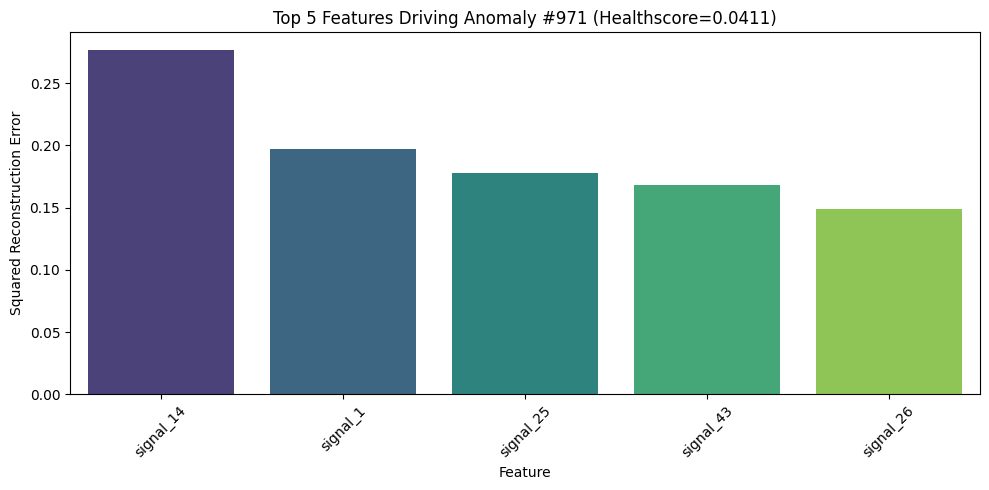

/tmp/ipython-input-2076322481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(errors), palette="viridis")


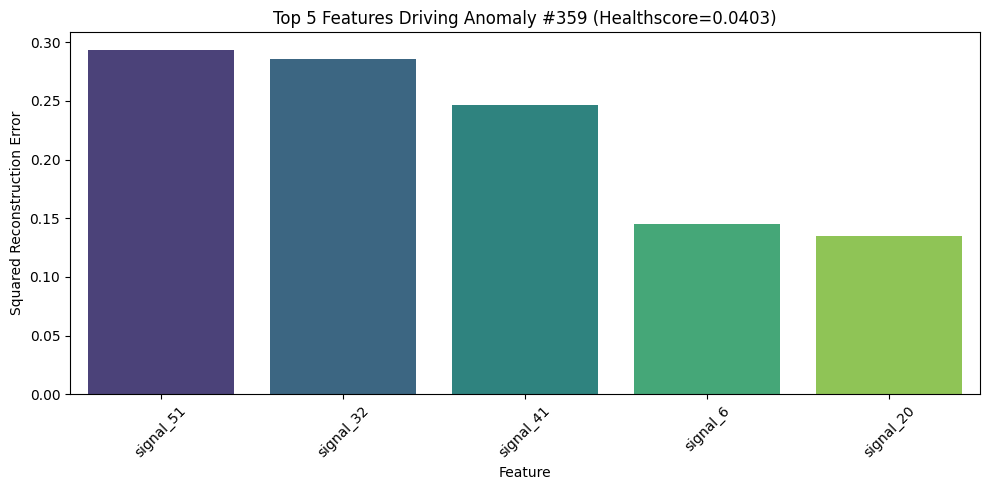

/tmp/ipython-input-2076322481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(features), y=list(errors), palette="viridis")


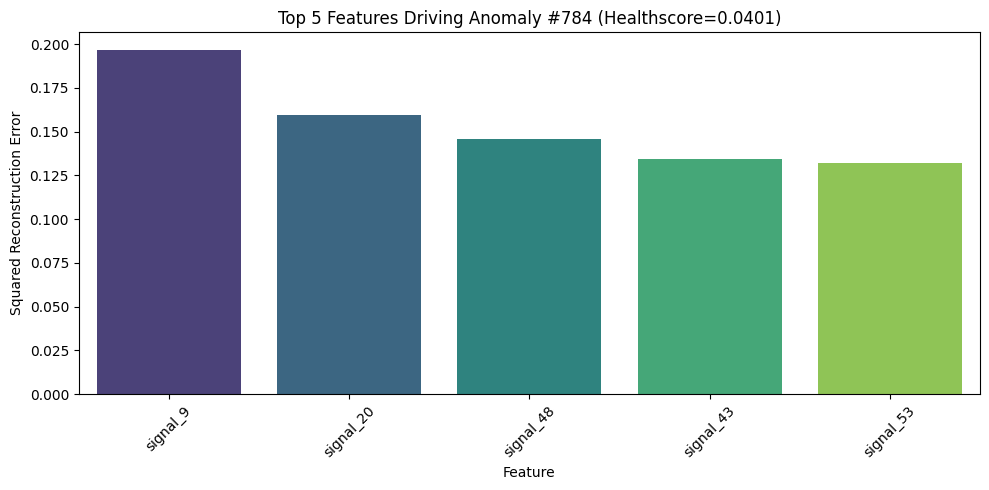

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

num_anomalies_to_plot = 3

top_anomalies = sorted(topk_features_per_anomaly, key=lambda x: x["healthscore"], reverse=True)[:num_anomalies_to_plot]

for i, anomaly in enumerate(top_anomalies, 1):
    features, errors = zip(*anomaly["top_features"])

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(features), y=list(errors), palette="viridis")
    plt.title(f"Top {K} Features Driving Anomaly #{anomaly['row_index']} (Healthscore={anomaly['healthscore']:.4f})")
    plt.ylabel("Squared Reconstruction Error")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


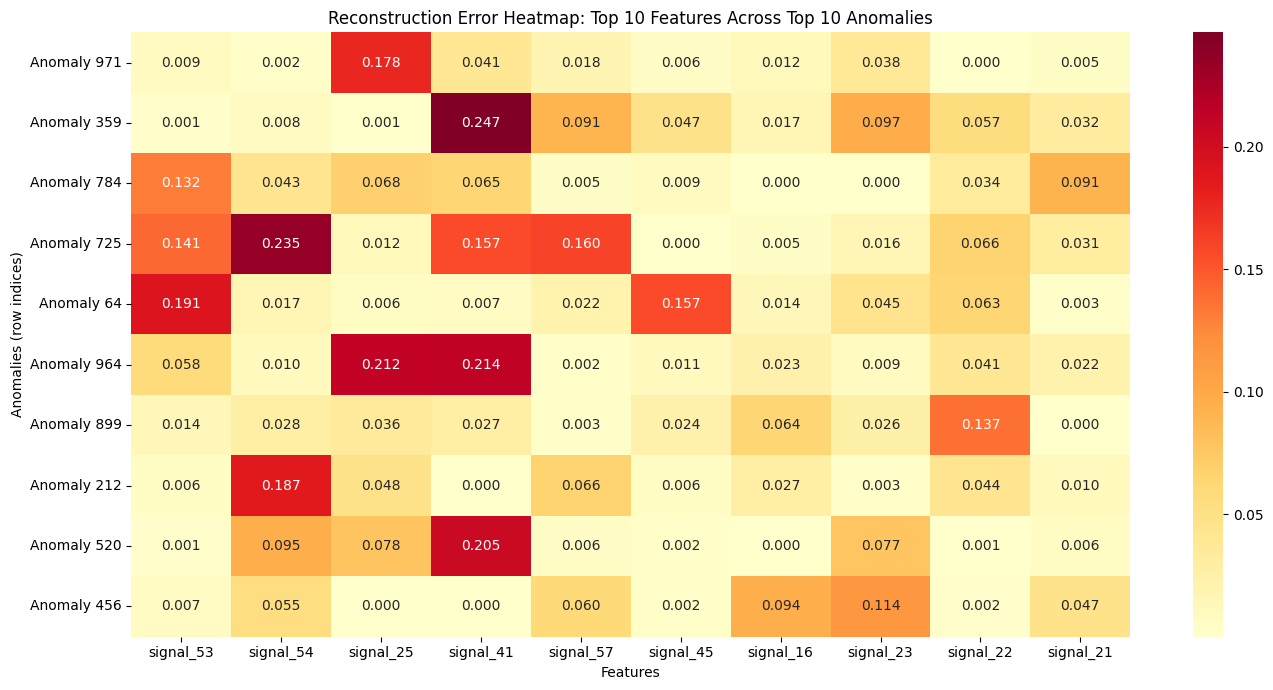

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

num_anomalies = 10
num_features = 10

top_anomalies_sorted = sorted(topk_features_per_anomaly, key=lambda x: x["healthscore"], reverse=True)[:num_anomalies]
anomaly_indices = [a["row_index"] for a in top_anomalies_sorted]

top_features_global = feature_importance_df["feature"].head(num_features).tolist()

heatmap_data = []

for anomaly in top_anomalies_sorted:
    row_idx = anomaly["row_index"]
    row_errors = errors_per_feature[row_idx]

    feat_idx_map = {f"signal_{i}": i-1 for i in range(1, 61)}

    errors_for_top_feats = [row_errors[feat_idx_map[feat]] for feat in top_features_global]
    heatmap_data.append(errors_for_top_feats)

heatmap_df = pd.DataFrame(heatmap_data, columns=top_features_global)
heatmap_df.index = [f"Anomaly {i}" for i in anomaly_indices]

plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title(f"Reconstruction Error Heatmap: Top {num_features} Features Across Top {num_anomalies} Anomalies")
plt.ylabel("Anomalies (row indices)")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


In [33]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.models as models
import tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import VectorAssembler, MinMaxScaler


model_save_path = "/content/drive/MyDrive/Colab Notebooks/best_autoencoder_selected_features.keras"

param_list = [
    {"epochs": 5, "batch_size": 32, "learning_rate": 0.001},
    {"epochs": 5, "batch_size": 64, "learning_rate": 0.001},
    {"epochs": 5, "batch_size": 32, "learning_rate": 0.0005}
]

best_val_loss = float("inf")
best_params = None

K_features = 15
top_features = feature_importance_df["feature"].head(K_features).tolist()

df_selected = df_scaled.select("Timestamp", "timestamp_secs", *[col(f) for f in top_features])

assembler_sel = VectorAssembler(inputCols=top_features, outputCol="features_selected")
df_vec_sel = assembler_sel.transform(df_selected)

scaler_sel = MinMaxScaler(inputCol="features_selected", outputCol="features_scaled_selected")
scaler_model_sel = scaler_sel.fit(df_vec_sel)
df_scaled_sel = scaler_model_sel.transform(df_vec_sel)


df_pandas_sel = df_scaled_sel.select("features_scaled_selected").toPandas()
features_np_sel = np.array(df_pandas_sel["features_scaled_selected"].tolist(), dtype=np.float32)


train_data_sel, val_data_sel = train_test_split(features_np_sel, test_size=0.2, random_state=42)


for params in param_list:
    K.clear_session()

    input_layer = layers.Input(shape=(K_features,))
    encoded = layers.Dense(max(10, K_features//2), activation="relu")(input_layer)
    encoded = layers.Dense(max(5, K_features//4), activation="relu")(encoded)
    decoded = layers.Dense(max(10, K_features//2), activation="relu")(encoded)
    output_layer = layers.Dense(K_features, activation="sigmoid")(decoded)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = optimizers.Adam(learning_rate=params["learning_rate"])
    model.compile(optimizer=optimizer, loss="mse")

    history = model.fit(
        train_data_sel, train_data_sel,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_data=(val_data_sel, val_data_sel),
        shuffle=True,
        verbose=0
    )

    val_loss = min(history.history["val_loss"])
    print(f"Params: {params} - Min Val Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f"\nBest params found: {best_params} with val loss: {best_val_loss}")

K.clear_session()

input_layer = layers.Input(shape=(K_features,))
encoded = layers.Dense(max(10, K_features//2), activation="relu")(input_layer)
encoded = layers.Dense(max(5, K_features//4), activation="relu")(encoded)
decoded = layers.Dense(max(10, K_features//2), activation="relu")(encoded)
output_layer = layers.Dense(K_features, activation="sigmoid")(decoded)

final_model = models.Model(inputs=input_layer, outputs=output_layer)
optimizer = optimizers.Adam(learning_rate=best_params["learning_rate"])
final_model.compile(optimizer=optimizer, loss="mse")

final_model.fit(
    train_data_sel, train_data_sel,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    validation_data=(val_data_sel, val_data_sel),
    shuffle=True,
    verbose=1
)

final_model.save(model_save_path)
print(f"Final retrained model saved at {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Params: {'epochs': 5, 'batch_size': 32, 'learning_rate': 0.001} - Min Val Loss: 0.026955680921673775
Params: {'epochs': 5, 'batch_size': 64, 'learning_rate': 0.001} - Min Val Loss: 0.028022831305861473
Params: {'epochs': 5, 'batch_size': 32, 'learning_rate': 0.0005} - Min Val Loss: 0.027564654126763344

Best params found: {'epochs': 5, 'batch_size': 32, 'learning_rate': 0.001} with val loss: 0.026955680921673775
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0289 - val_loss: 0.0280
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0277 - val_loss: 0.0276
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0279 - val_loss: 0.0273
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: 0.0269
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 - val_loss: 0.0266
Final retrained model saved at /content

+--------------------+--------------------+
|           Timestamp|         healthscore|
+--------------------+--------------------+
|01/01/2025 00:00:...|0.029718779027462006|
|01/01/2025 00:00:...|   0.026523532345891|
|01/01/2025 00:00:...|0.027666853740811348|
|01/01/2025 00:00:...| 0.02735273912549019|
|01/01/2025 00:00:...|0.026640964671969414|
+--------------------+--------------------+
only showing top 5 rows

Using healthscore anomaly threshold: 0.03105872869491577
+--------------------+--------------------+
|           Timestamp|         healthscore|
+--------------------+--------------------+
|01/01/2025 00:00:...| 0.03299269825220108|
|01/01/2025 00:01:...| 0.03815123066306114|
|01/01/2025 00:01:...| 0.03169426694512367|
|01/01/2025 00:01:...| 0.03508565574884415|
|01/01/2025 00:02:...|0.031224973499774933|
|01/01/2025 00:02:...|0.031469084322452545|
|01/01/2025 00:02:...|0.032931890338659286|
|01/01/2025 00:03:...|0.031707413494586945|
|01/01/2025 00:03:...|  0.033441938459

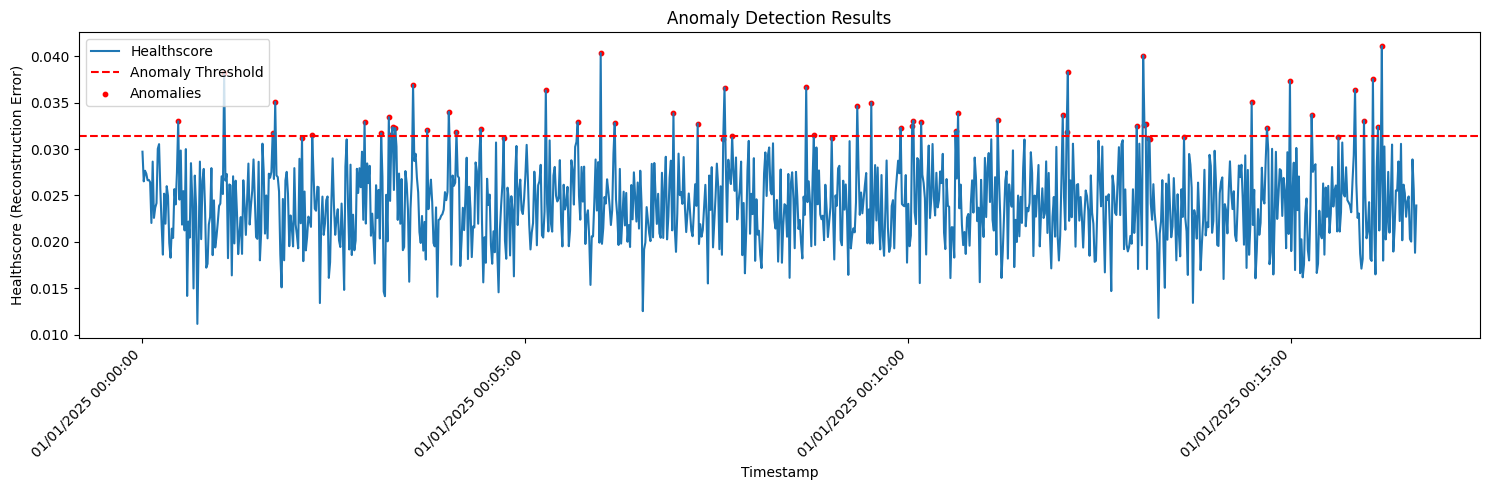

In [41]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType

df_with_health = df_indexed.join(healthscore_df, on="row_idx")

df_with_health.select("Timestamp", "healthscore").show(5)

threshold = df_with_health.approxQuantile("healthscore", [0.95], 0.01)[0]
print(f"Using healthscore anomaly threshold: {threshold}")

df_flagged = df_with_health.withColumn(
    "anomaly",
    when(col("healthscore") > threshold, 1).otherwise(0).cast(IntegerType())
)

df_flagged.filter(col("anomaly") == 1).select("Timestamp", "healthscore").show(10)

import matplotlib.pyplot as plt
import pandas as pd

pdf_flagged = df_flagged.select("Timestamp", "healthscore", "anomaly").orderBy("Timestamp").toPandas()

pdf_flagged["Timestamp"] = pd.to_datetime(pdf_flagged["Timestamp"], format="%m/%d/%Y %H:%M:%S:%f")


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd

plt.figure(figsize=(15,5))

plt.plot(pdf_flagged["Timestamp"], pdf_flagged["healthscore"], label="Healthscore")

threshold = pdf_flagged["healthscore"].quantile(0.95)
plt.axhline(y=threshold, color="red", linestyle="--", label="Anomaly Threshold")

anomaly_points = pdf_flagged[pdf_flagged["anomaly"] == 1]
plt.scatter(anomaly_points["Timestamp"], anomaly_points["healthscore"], color="red", s=10, label="Anomalies")

plt.xlabel("Timestamp")
plt.ylabel("Healthscore (Reconstruction Error)")
plt.title("Anomaly Detection Results")

if not pd.api.types.is_datetime64_any_dtype(pdf_flagged["Timestamp"]):
    pdf_flagged["Timestamp"] = pd.to_datetime(pdf_flagged["Timestamp"])

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d/%Y %H:%M:%S"))

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
import mlflow
import mlflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
import numpy as np

param_grid = [
    {"epochs": 20, "batch_size": 32, "learning_rate": 0.001},
    {"epochs": 20, "batch_size": 64, "learning_rate": 0.001},
    {"epochs": 20, "batch_size": 128, "learning_rate": 0.001},
    {"epochs": 20, "batch_size": 32, "learning_rate": 0.0005},
    {"epochs": 20, "batch_size": 64, "learning_rate": 0.0005},
    {"epochs": 30, "batch_size": 32, "learning_rate": 0.0001},
]

best_val_loss = float("inf")
best_params = None

mlflow.set_experiment("Autoencoder_Hyperparam_Tuning")

for params in param_grid:
    K.clear_session()
    with mlflow.start_run():
        input_layer = layers.Input(shape=(K_features,))
        encoded = layers.Dense(max(10, K_features // 2), activation="relu")(input_layer)
        encoded = layers.Dense(max(5, K_features // 4), activation="relu")(encoded)
        decoded = layers.Dense(max(10, K_features // 2), activation="relu")(encoded)
        output_layer = layers.Dense(K_features, activation="sigmoid")(decoded)

        model = models.Model(inputs=input_layer, outputs=output_layer)
        optimizer = optimizers.Adam(learning_rate=params["learning_rate"])
        model.compile(optimizer=optimizer, loss="mse")

        history = model.fit(
            train_data_sel,
            train_data_sel,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            validation_data=(val_data_sel, val_data_sel),
            shuffle=True,
            verbose=0
        )

        val_loss = min(history.history["val_loss"])

        mlflow.log_params(params)
        mlflow.log_metric("min_val_loss", val_loss)
        mlflow.keras.log_model(model, "model")

        print(f"Params: {params} - Min Val Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params

print(f"\nBest params: {best_params} with val loss: {best_val_loss}")

K.clear_session()
input_layer = layers.Input(shape=(K_features,))
encoded = layers.Dense(max(10, K_features // 2), activation="relu")(input_layer)
encoded = layers.Dense(max(5, K_features // 4), activation="relu")(encoded)
decoded = layers.Dense(max(10, K_features // 2), activation="relu")(encoded)
output_layer = layers.Dense(K_features, activation="sigmoid")(decoded)

final_model = models.Model(inputs=input_layer, outputs=output_layer)
optimizer = optimizers.Adam(learning_rate=best_params["learning_rate"])
final_model.compile(optimizer=optimizer, loss="mse")

final_model.fit(
    train_data_sel,
    train_data_sel,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    validation_data=(val_data_sel, val_data_sel),
    shuffle=True,
    verbose=1
)

final_model.save(model_save_path)
print(f"Final model retrained and saved at {model_save_path}")


2025/08/10 22:07:52 INFO mlflow.tracking.fluent: Experiment with name 'Autoencoder_Hyperparam_Tuning' does not exist. Creating a new experiment.
2025/08/10 22:07:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:07:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:08:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.001} - Min Val Loss: 0.02479017712175846


2025/08/10 22:08:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:08:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:08:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.001} - Min Val Loss: 0.024905290454626083


2025/08/10 22:08:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:08:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:08:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 20, 'batch_size': 128, 'learning_rate': 0.001} - Min Val Loss: 0.026505714282393456


2025/08/10 22:08:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:08:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:09:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.0005} - Min Val Loss: 0.025562526658177376


2025/08/10 22:09:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:09:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:09:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 20, 'batch_size': 64, 'learning_rate': 0.0005} - Min Val Loss: 0.02814236842095852


2025/08/10 22:09:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/10 22:09:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/08/10 22:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Params: {'epochs': 30, 'batch_size': 32, 'learning_rate': 0.0001} - Min Val Loss: 0.027564268559217453

Best params: {'epochs': 20, 'batch_size': 32, 'learning_rate': 0.001} with val loss: 0.02479017712175846
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0290 - val_loss: 0.0280
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 - val_loss: 0.0277
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0273 - val_loss: 0.0273
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0278 - val_loss: 0.0270
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0267
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 0.0263
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - val_loss: 0.0260
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━

In [48]:
import os
from pyspark.ml import PipelineModel
import tensorflow as tf
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

preprocessing_path = "/content/drive/MyDrive/preprocessing_pipeline"

assembler_path = os.path.join(preprocessing_path, "vector_assembler")
scaler_path = os.path.join(preprocessing_path, "minmax_scaler")

assembler.write().overwrite().save(assembler_path)
scaler_model.write().overwrite().save(scaler_path)

print(f"Saved assembler at: {assembler_path}")
print(f"Saved scaler at: {scaler_path}")

keras_model_path = "/content/drive/MyDrive/best_autoencoder.keras"
autoencoder.save(keras_model_path)
print(f"Saved Keras model at: {keras_model_path}")

loaded_model = tf.keras.models.load_model(keras_model_path)


def predict_healthscore(features):
    """
    Input: features as a list or vector of floats (scaled features)
    Output: healthscore (float)
    """
    import numpy as np
    features_np = np.array(features).reshape(1, -1)
    reconstructed = loaded_model.predict(features_np)
    mse = np.mean(np.square(features_np - reconstructed))
    return float(mse)

healthscore_udf = udf(predict_healthscore, DoubleType())


df_inference = df_scaled.withColumn("healthscore", healthscore_udf("features"))

df_inference.select("Timestamp", "healthscore").show(5, truncate=False)

assembler_sel.write().overwrite().save("/content/drive/MyDrive/vector_assembler_sel")
scaler_model_sel.write().overwrite().save("/content/drive/MyDrive/minmax_scaler_sel")

print("Saved VectorAssembler and MinMaxScaler for selected features.")


Saved assembler at: /content/drive/MyDrive/preprocessing_pipeline/vector_assembler
Saved scaler at: /content/drive/MyDrive/preprocessing_pipeline/minmax_scaler
Saved Keras model at: /content/drive/MyDrive/best_autoencoder.keras
+-----------------------+--------------------+
|Timestamp              |healthscore         |
+-----------------------+--------------------+
|01/01/2025 00:00:00:000|0.029718779361718514|
|01/01/2025 00:00:01:000|0.026523532030311582|
|01/01/2025 00:00:02:000|0.027666855089030346|
|01/01/2025 00:00:03:000|0.02735273994466396 |
|01/01/2025 00:00:04:000|0.0266409642763527  |
+-----------------------+--------------------+
only showing top 5 rows

Saved VectorAssembler and MinMaxScaler for selected features.


In [51]:
import os
from pyspark.ml.feature import VectorAssembler, MinMaxScalerModel
import tensorflow as tf
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

preprocessing_path = "/content/drive/MyDrive/preprocessing_pipeline"
assembler_path = os.path.join(preprocessing_path, "vector_assembler")
scaler_path = os.path.join(preprocessing_path, "minmax_scaler")
keras_model_path = "/content/drive/MyDrive/best_autoencoder.keras"

assembler_loaded = VectorAssembler.load(assembler_path)
scaler_loaded = MinMaxScalerModel.load(scaler_path)

print(f"Loaded VectorAssembler from: {assembler_path}")
print(f"Loaded MinMaxScaler from: {scaler_path}")

loaded_model = tf.keras.models.load_model(keras_model_path)
print(f"Loaded Keras model from: {keras_model_path}")

def predict_healthscore(features):
    import numpy as np
    features_np = np.array(features).reshape(1, -1)
    reconstructed = loaded_model.predict(features_np)
    mse = float(np.mean(np.square(features_np - reconstructed)))
    return mse

healthscore_udf = udf(predict_healthscore, DoubleType())

df_vec = assembler_loaded.transform(df)

df_scaled = scaler_loaded.transform(df_vec)

df_inference = df_scaled.withColumn("healthscore", healthscore_udf("features"))

df_inference.select("Timestamp", "healthscore").show(5, truncate=False)


Loaded VectorAssembler from: /content/drive/MyDrive/preprocessing_pipeline/vector_assembler
Loaded MinMaxScaler from: /content/drive/MyDrive/preprocessing_pipeline/minmax_scaler
Loaded Keras model from: /content/drive/MyDrive/best_autoencoder.keras
+-----------------------+--------------------+
|Timestamp              |healthscore         |
+-----------------------+--------------------+
|01/01/2025 00:00:00:000|0.029718779361718514|
|01/01/2025 00:00:01:000|0.026523532030311582|
|01/01/2025 00:00:02:000|0.027666855089030346|
|01/01/2025 00:00:03:000|0.02735273994466396 |
|01/01/2025 00:00:04:000|0.0266409642763527  |
+-----------------------+--------------------+
only showing top 5 rows

